## Import Necessary Libraries


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset


In [2]:
# Assuming you have a Pandas DataFrame 'df' with your data
dataset_file = "splitted_by_sensor/Dataset_Sensor_2.csv"

dataset = pd.read_csv(dataset_file)

print("Dataset Columns", dataset.columns)

Dataset Columns Index(['id', 'created_at', 'updated_at', 'deleted_at', 'name', 'voltage',
       'current', 'power', 'power_factor', 'frequency', 'energy',
       'apparent_power', 'reactive_power'],
      dtype='object')


## Preprocess Data


In [3]:
# Convert created_at to datetime if necessary
dataset["created_at"] = pd.to_datetime(dataset["created_at"], format="ISO8601")

# Convert power to kWh
dataset["power"] = dataset["power"] / 1000

# Extract power data for scaling
power_data = dataset[["power"]].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
power_data_scaled = scaler.fit_transform(power_data)

In [4]:
dataset["time_diff"] = dataset["created_at"].diff()

average_interval = dataset["time_diff"].mean().total_seconds()

## Input Sequences and Corresponding Targets


In [5]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i : i + seq_length]
        label = data[i + seq_length][
            0
        ]  # Assuming we're predicting 'power', which is the first column
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [6]:
SEQ_LENGTH = 24  # Using 24-hour sequence length for daily prediction
X, y = create_sequences(power_data_scaled, SEQ_LENGTH)

# Reshape X for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

## Split Dataset


In [7]:
train_size = int(0.80 * len(X))
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

print(f"Training set size: {train_X.shape}, Test set size: {test_X.shape}")

Training set size: (1660959, 24, 1), Test set size: (415240, 24, 1)


## Define LSTM Model


In [8]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(
            64, return_sequences=False, input_shape=(SEQ_LENGTH, 1)
        ),  # LSTM with 64 units
        tf.keras.layers.Dropout(0.2),  # Dropout regularization
        tf.keras.layers.Dense(1),  # Output layer for predicting power
    ]
)

d:\Daffa Titip\power-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train Model


In [9]:
model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(train_X, train_y, epochs=32, batch_size=64, validation_split=0.25)

Epoch 1/32
19465/19465 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - loss: 2.9074e-04 - val_loss: 6.4782e-05
Epoch 2/32
19465/19465 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - loss: 1.6037e-04 - val_loss: 7.6013e-05
Epoch 3/32
19465/19465 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - loss: 1.4741e-04 - val_loss: 7.1946e-05
Epoch 4/32
19465/19465 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - loss: 1.4856e-04 - val_loss: 6.5481e-05
Epoch 5/32
19465/19465 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - loss: 1.5120e-04 - val_loss: 9.6787e-05
Epoch 6/32
19465/19465 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - loss: 1.4561e-04 - val_loss: 7.2249e-05
Epoch 7/32
19465/19465 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - loss: 1.4897e-04 - val_loss: 8.7970e-05
Epoch 8/32
19465/19465 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - loss: 1.4557e-04 - val_loss: 5.3044e-05
Epoch 9/32
19465/19465 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - loss: 1.4350e-04 - val_loss: 9.1036e-05
Epoch 10/32
19465/19465 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - loss: 1.3862e-04 - val_loss: 5.7380e-05

## Predict the Test Set


In [10]:
# Predict the power for each timestep
predictions = model.predict(test_X)

# Inverse transform predictions to original scale (kWh scale)
predictions_reshaped = predictions.reshape(-1, 1)
predictions_original = scaler.inverse_transform(predictions_reshaped)

# Convertn the prediction into kWh
interval_in_hours = average_interval / 3600  # Convert 2.83 seconds to hours
predictions_kwh = predictions_original * interval_in_hours

# Calculate total predicted power for the test set in kWh
predicted_power = predictions_kwh.sum()

# Cost calculation (assumed cost per kWh is 1500 IDR)
cost_per_kwh = 1500
predicted_cost = predicted_power * cost_per_kwh

12977/12977 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


## Evaluate Model

In [11]:
# Inverse transform test_y to original scale
test_y_original = scaler.inverse_transform(test_y.reshape(-1, 1))

mse = mean_squared_error(test_y_original, predictions_original)
mae = mean_absolute_error(test_y_original, predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(test_y_original, predictions_original)

## Visualize Prediction in a Plot

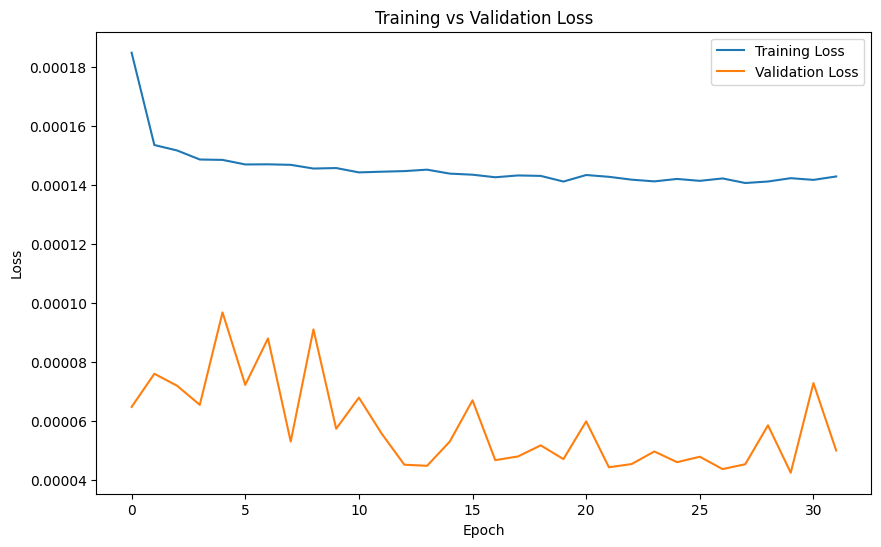

In [12]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


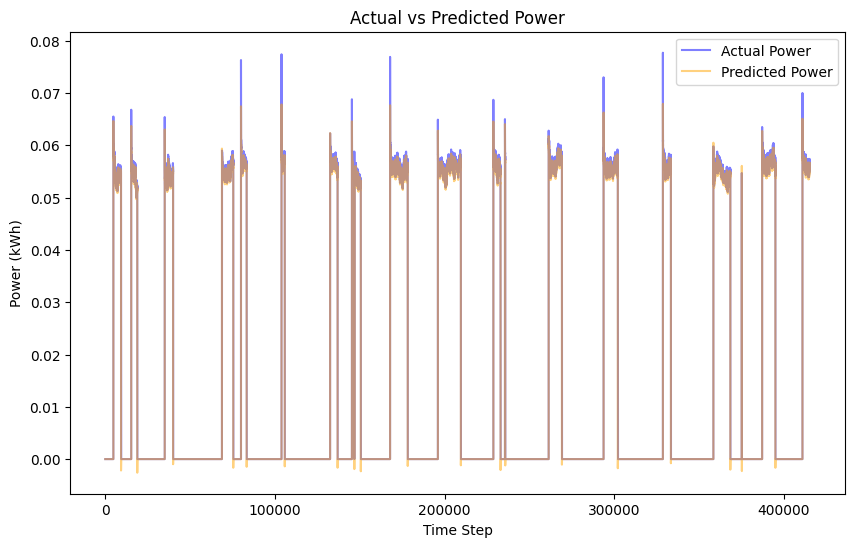

In [13]:
# Use transparency for the predicted line to better see overlap
plt.figure(figsize=(10, 6))
plt.plot(test_y_original, label='Actual Power', color='blue', alpha=0.5)
plt.plot(predictions_original, label='Predicted Power', color='orange', alpha=0.5)  # Set alpha for transparency
plt.title('Actual vs Predicted Power')
plt.xlabel('Time Step')
plt.ylabel('Power (kWh)')
plt.legend()
plt.show()

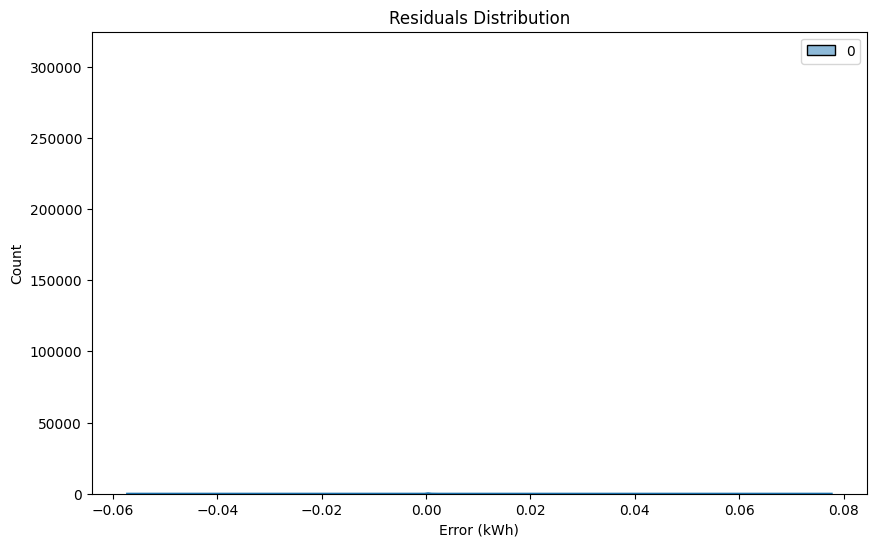

In [14]:
residuals = test_y_original - predictions_original

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Error (kWh)')
plt.show()

## Result

In [15]:
print(f"Predicted power usage: {predicted_power:.2f} kWh")
print(f"Estimated cost: {predicted_cost:.2f} IDR")

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Predicted power usage: 4.61 kWh
Estimated cost: 6912.24 IDR
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0002
Root Mean Squared Error (RMSE): 0.0006
R² Score: 0.9993
